In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import base64
import requests
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report
import joblib

# **Classification of books with multimodal data over custom dataset**
## "Judge the book by its cover"

>*“The purpose of (scientific) computing is insight, not numbers.”*

Richard Hamming


## **Summary**
In this project we will apply different data science and machine learning techniques for classification over a custom dataset of annotated books to predict the book category. The practical implications of such classificator could be in the domain of automated sorting for libraries and bookstores which can use such a system to automatically categorize new books, making inventory management more efficient. Other practical use can be in recommendation systems where this system can feed into recommendation engines, suggesting books to customers based on their past preferences. We will use annotated data for the books from biblioman.chitanka.info, a sub project to chitanka.info dedicated in making an extensive annotated database for the books. We will make EDA over the dataset to identify possible usefull features, and we will make new features as well. We will then train and evaluate with cross validation a number of classical machine learning models - Logistic Regression, Decision Tree, Random Forest and SVC to identify the convinient architecture and hyperparameters. When the best model is selected and trained we will inspect its performance over seen and unseen data. In the end we hope to be able to "Judge the book by its cover" using the Open AI API for GPT 4.

## **1. Data aquisition**

The datasets are aquired from the database of biblioman.chitanka.info("https://biblioman.chitanka.info/biblioman.sql.gz"). We will use `book` and `book_category` tables which are extracted with MySQL Workbench 8  as they are  the database as follows. For the sake of the data consistency we populated the `book_category` table column `nr_of_books` with the actual number of books from the `book` table using this query: 

```UPDATE book_category AS bc
SET bc.nr_of_books = (
    SELECT COUNT(*) 
    FROM book AS b
    WHERE b.category_id = bc.id
);

Let's download the data!

In [2]:
##Downloading the dataset.
##If on Linux:
#!wget http://preslaff.laboletory.com/preslaff/data_science_final_project/data.zip
##Then unzip the file

#Python code
url = "http://preslaff.laboletory.com/preslaff/ml_final_project/data.zip"
output_file_path = "data.zip"

response = requests.get(url, stream=True)

if response.status_code == 200:
    total_size = int(response.headers.get('content-length', 0))
    chunk_size = 1024  # You can adjust the chunk size as needed
    progress_bar = tqdm(total=total_size, unit='B', unit_scale=True)

    with open(output_file_path, "wb") as f:
        for data in response.iter_content(chunk_size=chunk_size):
            progress_bar.update(len(data))
            f.write(data)

    progress_bar.close()
    print("File downloaded successfully.")
else:
    print("Failed to download the file.")

#Or just copy and paste in your browser the hyperlink http://preslaff.laboletory.com/preslaff/ml_final_project/data.zip 

100%|████████████████████████████████████████████████████████████████████████████████████████| 253M/253M [01:07<00:00, 3.72MB/s]

File downloaded successfully.


Now we have:

- The dataset with the book's information is in the file `updated_dataset.csv`
- The dataset with the book's categories is in the file `book_category_1.csv`
- The second testing dataset is in the file `never_seen_data.csv`

The saved models are in directory `saved_models`. For the last part of the project we will use images with covers from the books in the  dataset to predict. Covers can be found in the `covers` directory. Some drafts in `drafts` directory.

In [4]:
books_data = pd.read_csv("updated_dataset.csv")

In [8]:
books_category = pd.read_csv("book_category_1.csv")

In [6]:
books_data

,id,title,annotation,content_type,publisher,sequence,sequence_nr,info_sources,publishing_year,nationality,...,created_by_user_id,available_at,media,completed_by_user_id,completed_by,has_only_scans,nb_content_files,verified_count,is_public,atelie_id
0,1,Трима другари,NaN,роман,Издателство на Отечествения фронт,NaN,NaN,"Сканове, DjVu: Karel",1984,немска,...,1,NaN,хартия,NaN,NaN,0,1,0,0,23742.0
1,2,Без дом,NaN,роман,„Народна младеж“ — издателство на ЦК на ДКМС,NaN,NaN,NaN,1988,френска,...,24,NaN,хартия,NaN,NaN,0,0,0,0,NaN
2,3,Съкровището в сребърното езеро,NaN,роман,ДИ „Отечество“,NaN,NaN,NaN,1984,немска,...,24,NaN,хартия,NaN,NaN,0,0,0,0,NaN
3,4,Къща от карти,Базиран на личния опит на автора Майкъл Добс -...,роман,Сиела Норма АД,NaN,NaN,NaN,2014,английска,...,24,2021-01-01,хартия,NaN,NaN,0,1,0,0,NaN
4,5,Летище,Един отчаян от живота човек решава да извърши ...,роман,Георги Бакалов,Библиотека „Галактика“,15.0,NaN,1990,американска,...,24,NaN,хартия,NaN,NaN,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19480,19481,Завръщане в Аляска,"Изисква се желязна воля, за да спасиш сам себе...",роман (не е указано),СББ Медиа АД,Световни бестселъри,NaN,Цената е взета от сайтовете на книжарниците.,2023,американска,...,52,NaN,хартия,NaN,NaN,0,0,0,0,NaN
19481,19482,Дневникът на госпожица Джоун Мартин,Вирджиния Улф (1882–1941) е призната за една о...,сборник разкази,Издателство „Изток-Запад“,Колекция „Плеяди“,NaN,NaN,2021,британска,...,52,NaN,хартия,NaN,NaN,0,0,0,0,NaN
19482,19483,Победителят получава всичко,"Ивлин Уо (1903–1966), един от големите майстор...",сборник,ФАМА,Класика (ФАМА),84.0,NaN,2008,английска,...,52,NaN,хартия,NaN,NaN,0,0,0,0,NaN
19483,19484,Покана за Прованс,"Къде ще бъдете, когато любовта идва чукайки на...",роман (не е указано),ИК „Калпазанов“,Колекция „Елизабет Адлър“,NaN,NaN,2006,английска,...,2150,NaN,хартия,NaN,NaN,0,0,0,0,NaN


In [7]:
books_data.shape

(19485, 104)

The dataset with the meta information about the books consists of 19485 books with 104 columns. 

In [8]:
books_category[books_category.parent_id.isna()]

,id,tree_root,parent_id,name,slug,lft,lvl,rgt,nr_of_books
0,1,1,NaN,"Наука, технологии, образование",nauka-technologii-obrazovanie,1,0,74,10
37,38,38,NaN,Общество и култура,obshtestvo-i-cultura,1,0,58,13
66,67,67,NaN,Художествена литература,hudozhestvena-literatura,1,0,144,131


The dataset with the books categories consists of 138! categories with 9 columns. As it looks the category structure has an hierarchy.

In [9]:
books_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           138 non-null    int64  
 1   tree_root    138 non-null    int64  
 2   parent_id    135 non-null    float64
 3   name         138 non-null    object 
 4   slug         138 non-null    object 
 5   lft          138 non-null    int64  
 6   lvl          138 non-null    int64  
 7   rgt          138 non-null    int64  
 8   nr_of_books  138 non-null    int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 9.8+ KB


We have NaN in `parent_id`. We will add 1000 to the `id` as `parent_id` for all root categories.

In [9]:
books_category.parent_id = books_category.parent_id.fillna(books_category.id + 1000)

In [11]:
books_category

,id,tree_root,parent_id,name,slug,lft,lvl,rgt,nr_of_books
0,1,1,1001.0,"Наука, технологии, образование",nauka-technologii-obrazovanie,1,0,74,10
1,2,1,1.0,Научнопопулярна литература,nauchno-populjarna-literatura,2,1,3,253
2,3,1,1.0,Образование,obrazovanie,4,1,11,9
3,4,1,3.0,Дидактика,didactica,5,2,6,0
4,5,1,3.0,Педагогика,pedagogika,7,2,8,5
...,...,...,...,...,...,...,...,...,...
133,134,67,133.0,Научна фантастика,nauchna-fantastika,133,2,134,918
134,135,67,133.0,Фентъзи,fantasy,135,2,136,1352
135,136,67,133.0,Хорър,horror,137,2,138,217
136,137,67,67.0,Фолклор,folclor,140,1,141,15


In [12]:
books_category[books_category.parent_id.isna()]

,id,tree_root,parent_id,name,slug,lft,lvl,rgt,nr_of_books


## **2. Data exploration**

### **2.1. Books dataset**
Let's see the columns of the books dataset

In [13]:
books_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19485 entries, 0 to 19484
Data columns (total 104 columns):
 #    Column                            Dtype  
---   ------                            -----  
 0    id                                int64  
 1    title                             object 
 2    annotation                        object 
 3    content_type                      object 
 4    publisher                         object 
 5    sequence                          object 
 6    sequence_nr                       float64
 7    info_sources                      object 
 8    publishing_year                   object 
 9    nationality                       object 
 10   edition                           object 
 11   printing_house                    object 
 12   printer_sheets                    object 
 13   format                            object 
 14   page_count                        float64
 15   price                             object 
 16   binding             

- We can see that some columns consist with information about the contents of the book (such as 'title', 'subtitle', 'author', 'annotation', 'content_type', 'publisher', 'sequence', 'sequence_nr', 'format', 'page_count', 'artist', 'cover', 'back_cover', 'corrector', etc. ).

- Some are related with the activity of biblioman users (such as 'created_at', 'updated_at', 'created_by', 'created_at', 'updated_at', 'notes_about_original', 'is_incomplete', 'locked_at', 'locked_by', 'reason_why_incomplete', 'category_id', 'admin_comment', 'ocred_text', 'created_by_user_id', 'available_at', 'media', 'completed_by_user_id', 'completed_by', 'has_only_scans', 'nb_content_files', 'verified_count', 'is_public', 'atelie_id' ).There is a lot of missing information in some columns and a lot of columns with administrative information specific to the biblioman platform.

Most of the columns (87) contain text. Only 17 are numbers. It looks like we will have to make a significant preprocessing before we begin modeling.

### **2.2. Target variable (category_id)**

#### **Distribution**

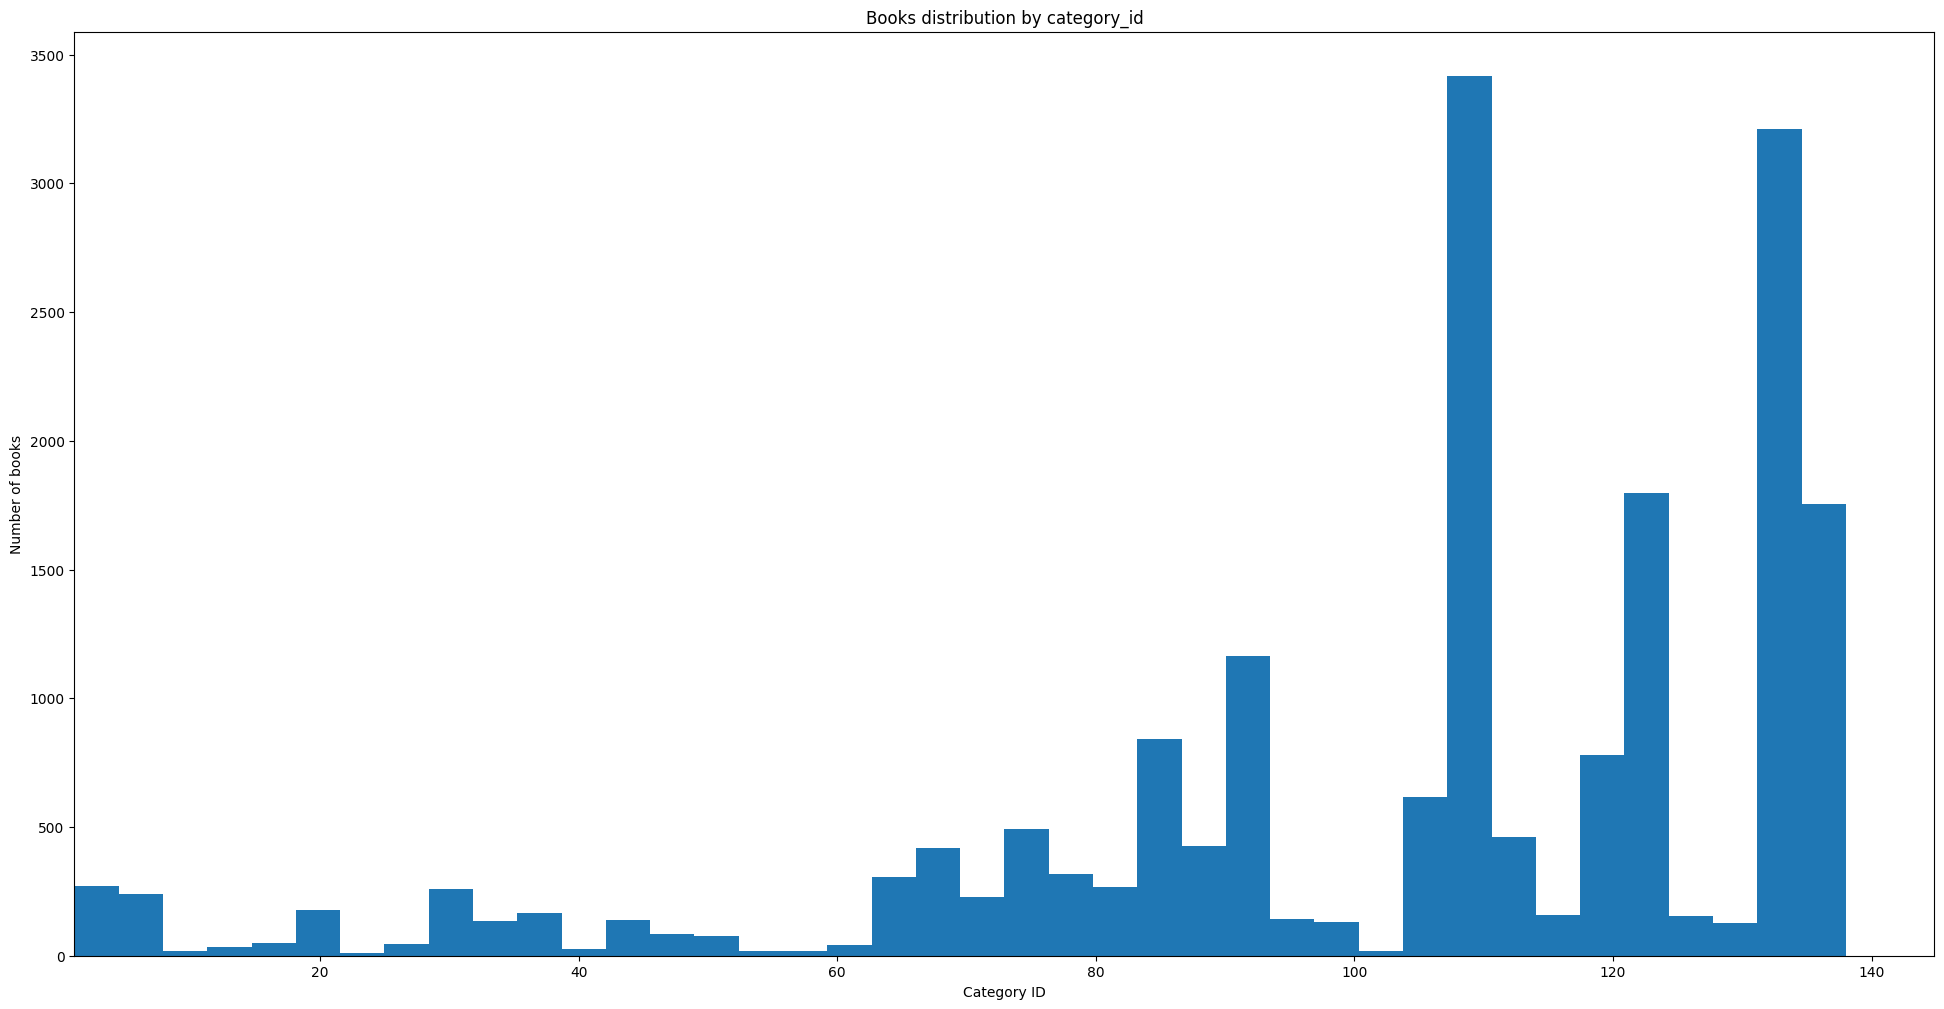

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24,12))
plt.hist(books_data.category_id, bins=40)
plt.title("Books distribution by category_id")
plt.xlabel("Category ID")
plt.ylabel("Number of books")
plt.xlim(1)
plt.show()

#'auto', 'fd', 'doane', 'scott', 'stone', 'rice', 'sturges', or 'sqrt'

As we can see the distribution of the classes (category_id) is imbalanced. We have to keep in mind that in the training phase.

#### **Empty categories**

These are the categories (classes) without any book.

In [15]:
books_category[books_category.nr_of_books == 0]

,id,tree_root,parent_id,name,slug,lft,lvl,rgt,nr_of_books
3,4,1,3.0,Дидактика,didactica,5,2,6,0
10,11,1,7.0,Екология,ekologia,19,2,20,0
22,23,1,22.0,Високи технологии,visoki-technologii,43,2,44,0
58,59,38,57.0,Култура,kultura,41,2,42,0
103,104,67,99.0,Сценарии,scenarii,73,2,74,0
123,124,67,122.0,Репортажи,reportazhi,113,2,114,0


### **2.3. Categories structure**

As we saw in the data aquisition preview, categories in the dataset have hierarchical structure. This could be usefull in the training optimisation process.

In [16]:
books_category.groupby("lvl").size()

lvl
0      3
1     29
2    106
dtype: int64

We have 3 root categories in level 0, 29 in the first level and 106 in level 2.

## **3. Features selection**

### **3.1. Dealing with the entropy**

At first glance and counting on the domain knowledge we can identify some of the most distinctive features of a book as - Title, Author, Annotation, Content type, Number of pages, Publisher, Translator, Chitanka category_id. All the administrative information about the biblioman users will be ignored. All time related information is misleading too because of the nature of book publishing - one book can be published more than once in different periods of time.

But how not to get lost in this abundance of possible features?

Let's see some statistics about the columns in the dataset. We will use the columns entropy and their missing information proportion as metrics below:


> We will use this expression for describing the entropy:

$H(X) = - \sum P(x_i) \cdot \log_2(P(x_i))$

Where:
- $H(X)$ is the entropy of the random variable $(X)$.
- $P(x_i)$ is the probability of the i-th unique value occurring in the dataset.

In [17]:
# Function to calculate entropy
def calculate_entropy(column):
    column_filled = column.fillna('Missing')
    frequencies = column_filled.value_counts()
    probabilities = frequencies / len(column_filled)
    # entropy = -np.sum(probabilities * np.log2(probabilities))
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# List for storing data
features_list = []

for col in books_data:
    entropy = calculate_entropy(books_data[col])
    missing_prop = books_data[col].isnull().mean()
    features_list.append({'Column': col, 'Entropy': entropy, 'Missing Value Proportion': missing_prop})

In [18]:
# Convert list of dictionaries to DataFrame
features_list = pd.DataFrame(features_list)

In [19]:
# Sort the DataFrame by 'Entropy' in descending order and 'Missing Value Proportion' in descending order
features_list_sorted = features_list.sort_values(by=["Entropy", "Missing Value Proportion"], ascending=[False, False])

# Filter the rows where 'Missing Value Proportion' is less than 0.3
features_list_sorted[features_list_sorted["Missing Value Proportion"] < 0.1]


,Column,Entropy,Missing Value Proportion
0,id,14.250076,0.000000
40,updated_at,14.249974,0.000000
39,created_at,14.249871,0.000000
38,cover,14.249480,0.000257
1,title,13.857328,0.000000
42,back_cover,13.642843,0.059636
23,author,11.900600,0.011188
15,price,9.299578,0.088324
4,publisher,8.470699,0.003952
14,page_count,6.985041,0.062304


The table above shows some pretty good results. The bigger the Entropy the more diverse is the information in the column. The smaller the Missing Value Proportion, the fewer records with missing values there are in the column. 

Let's apply some domain knowledge and analyse the results:

- `id` - As expected with biggest diversity and smallest missing values (after all this is a unique key in the dtabase), but with no real information value.
- `updated_at`, `created_at` - Fields related to the biblioman user activity
- `cover`, `back_cover` - Contains the filename of the book covers as are uploaded to biblioman, not an information we could use to predict the book `category_id`
- `title`, `author`, `annotation` - Features that might have significant influence, after all one author usually is known about it's romans or novels or poems. The title and the annotation can contain specific keywords that can direct the classifier to the correct class.
- `notes_about_original` - Duplicates the title and author but in the original language of the book
- `price` - There is a significant problem about using the price as classification feature. Prices are from different time periods and there has been currency denomination not long in the past. 
- `translator` - Usually tranlators specialize in specific literature and/or authors. This column could be usefull for `category_id` classification
- `isbn`, `isbn_clean`, `universal_decimal_classification` - Another unique identifiers as the `id`. 
- `editor` - Book editors can work for publishing houses, literary agencies, or as freelancers. Some editors specialize in specific genres or subjects, while others have a broader range of expertise.
- `publisher` - Publishers often select specific genre or book categories, such as book series or authors.
- `printing_house` - This is related with the technical process of printing the book, making the book binding. One printing house can print very diverse type of literature.
- `corrector` - A technical job in the publishing business related with identifying and correction in the text.
- `page_count` - Specifies the number of the pages of a book. Can relate to the book category `category_id`.
- `genre` - Can relate to the book category, but with a lot of missing values. In a manner this duplicates the content_type field.
- `publishing_year` - One  book originating from 19-th or from 21-st century can be published in the same year.
- `printer_sheets`, `format` - The number of the printing sheets used to print the book according to the chosen format. One book from the same `category_id` can be in different formats.
- `artist` - This is the artist that designed the book cover. There are a lot of missing records, and may be misleading 
- `publisher_address` - Geographical address of the publisher. Duplicated the information in publisher and doesn't add additional information value
- `category_id` - This is the target variable!
- `date_of_translation` - Another date that can have different importance in similar cases because it depends of the business decision when a book to be translataed in Bulgarian.
- `nationality`, `translated_from_language` - Could be usefull but it is not very clear. Books from one nationality/language can be the same `category_id` and vice versa.
- `content_type` - User annotation about the type of the book. Can be a novel, a collection of short stories, an anthology, a collection of poems etc.
- `nb_scans`, `created_by_user_id`, `created_by` - Administrative fields related to the biblioman user activity

Let's select our features! We will use these specific features:

In [20]:
books_features = books_data[["title", "author", "annotation", "translator", "nationality", "publisher", "page_count", "content_type", "category_id"]]

### **3.2. Cleaning and tyding the features dataset**

Let's check the features quality.

In [21]:
books_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19485 entries, 0 to 19484
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         19485 non-null  object 
 1   author        19267 non-null  object 
 2   annotation    14530 non-null  object 
 3   translator    15119 non-null  object 
 4   nationality   16766 non-null  object 
 5   publisher     19408 non-null  object 
 6   page_count    18271 non-null  float64
 7   content_type  17827 non-null  object 
 8   category_id   19040 non-null  float64
dtypes: float64(2), object(7)
memory usage: 1.3+ MB


We have missing records in our features, as  we saw in 3.1. we can try to impute some of the features using the `author` column based on the assumption that a book from specific author will have the same `content_type` and `translator`. We can do the same with the target `category_id`. Let's check this assumptions, but first we will select an author.

In [22]:
books_features.groupby("author").size().sort_values(ascending=False)

author
Author not found                      230
Нора Робъртс                          161
Стивън Кинг                           112
Агата Кристи                          109
Даниел Стийл                           83
                                     ... 
И. С. Соколов-Микитов                   1
И. С. Конев                             1
И. Р. Григулевич                        1
И. Коринекъ                             1
ст. н. с. д-р Ангел Николов Зайков      1
Length: 7933, dtype: int64

> Romance and horror, what a combination! We choose the King.

In [23]:
books_features[books_features.author == "Стивън Кинг"]

,title,author,annotation,translator,nationality,publisher,page_count,content_type,category_id
176,Сияние,Стивън Кинг,NaN,Надя Баева,Американска,Народна култура,416.0,роман,136.0
177,Сейлъм`с Лот,Стивън Кинг,"Зaпуcтял и мрaчeн, Мaрcтънoвият дoм ce издигa ...",Любомир Николов,американска,ИК „Плеяда 7“,496.0,роман,136.0
912,Стрелецът,Стивън Кинг,"„Този роман е за мен като моя Кула, а героите ...",Милко Стоименов,американска (не е указана),ИК „Плеяда“,208.0,роман (не е указано),135.0
913,Трите карти,Стивън Кинг,"„Този роман е за мен като моя Кула, а героите ...",Милко Стоименов; Весела Прошкова,американска (не е указана),ИК „Плеяда“,352.0,роман (не е указано),135.0
914,Пустош,Стивън Кинг,NaN,Милко Стоименов; Весела Прошкова; Юлия Чернева,американска,ИК „Плеяда“,448.0,роман,135.0
...,...,...,...,...,...,...,...,...,...
19065,Романът на Лизи,Стивън Кинг,Лесно ли е да си жена на известен човек?„Не“ —...,Адриан Лазаровски; Павел Боянов,американска,Издателска къща Плеяда,576.0,роман (не е указано),136.0
19069,За писането,Стивън Кинг,"Блестящо построена, доброжелателна и вдъхновен...",Евелина Банева,американска,Издателство „Весела Люцканова“,256.0,NaN,32.0
19070,Роуз Мадър,Стивън Кинг,След четиринайсет години брак Роузи Даниелс вн...,Весела Еленкова,американска (не е указано),Издателска къща Плеяда,384.0,роман (не е указано),132.0
19073,"Момичето, което обичаше Том Гордън",Стивън Кинг,"Светът има зъби и може да те захапе с тях, ког...",Николина Николова,американска (не е указано),ИК „Пан ’96“ ООД,208.0,роман (не е указано),136.0


Not quite right for the `translator`, but we can take the most frequent record as the mode. We can do the same for `content_type`, `nationality`  and `category_id`.

Let's do it!

In [24]:
def impute_missing_values(dataset, column_to_impute):
    # Group by author and find the most common value for the column
    common_values = dataset.groupby('author')[column_to_impute].agg(lambda x: pd.Series.mode(x).iat[0] if not x.mode().empty else None)
    
    # Fill missing values
    for author, value in common_values.items():
        if value is not None:
            # Correct the .loc usage for conditional replacement
            dataset.loc[(dataset['author'] == author) & (dataset[column_to_impute].isna()), column_to_impute] = value
    return dataset

In [25]:
books_features = impute_missing_values(books_features, 'translator')

In [26]:
books_features = impute_missing_values(books_features, 'content_type')

In [27]:
books_features = impute_missing_values(books_features, 'category_id')

In [28]:
books_features = impute_missing_values(books_features, 'nationality')

In [29]:
books_features.nationality.isna().sum() #2719 before imputation

1380

In [30]:
books_features.translator.isna().sum() #4366 before imputation

4122

In [31]:
books_features.content_type.isna().sum() #1658 before imputation

944

In [32]:
books_features.category_id.isna().sum() #445 before imputation

229

Nice, we imputed 157 records in translator, 700 records in content_type and 215 in category_id. The next step will be to remove the missing records in the features but first we have to ensure that we will not lose the books without translator which are from Bulgarian authors. We will impute the `translator` column with the string "Missing" where `nationality` == "Българска" 

In [33]:
# books_features.locbooks_features'nationality'.str.lower() == 'българска', 'translator' = books_features.locbooks_features'nationality'.str.lower() == 'българска', 'translator'.fillna('Missing')

books_features.loc[books_features['nationality'].str.lower() == 'българска', 'translator'] = \
books_features.loc[books_features['nationality'].str.lower() == 'българска', 'translator'].fillna('Missing')


Dropping the NaN.

In [34]:
books_features = books_features.dropna()

In [35]:
books_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12562 entries, 3 to 19484
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         12562 non-null  object 
 1   author        12562 non-null  object 
 2   annotation    12562 non-null  object 
 3   translator    12562 non-null  object 
 4   nationality   12562 non-null  object 
 5   publisher     12562 non-null  object 
 6   page_count    12562 non-null  float64
 7   content_type  12562 non-null  object 
 8   category_id   12562 non-null  float64
dtypes: float64(2), object(7)
memory usage: 981.4+ KB


Transforming to integers the `page_count` and `category_id` column.

In [36]:
books_features['category_id'] = books_features['category_id'].astype(int)
books_features['page_count'] = books_features['page_count'].astype(int)

When everything is OK, let's make some feature engineering!

## **4. Feature engineering**

As we saw most of the data in the dataset is text. We will use OneHotEncoder for the `title`, `author`, `translator`, `nationality`, `publisher` and the `content_type`. We will use TfdifVectorizer for the `annotation` feature. We will use StandartScaler for `page_count` and will keep the `category_id` as it is, but may consider some engineering later. 

## **5. Preprocessing, training, inspection, interpretation and model selection**

According to our classification task, we will train a number of widely used models to select the proper architecture and hyperparamaters for further training and optimization. We will transform all of our text features with OneNotEncoder and the `annotation` column with TfidfVectorizer, because of the text complexity and volume. We will use StandartScaler for the `page_count` feature. We will use grid search with cross validation using GridSearchCV more to provide more sample sets for model validation.  

### **5.1. Preprocessing and initial training**

Defining feature columns

In [190]:
text_features = ["title", "author", "content_type", "publisher", "translator", "nationality"]
num_features = ['page_count']

Splitting the data

In [52]:
X = books_features.drop(columns="category_id") 
y = books_features["category_id"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Making the pipeline

In [89]:
# preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("annotation_tfidf", TfidfVectorizer(), "annotation"),
        ("text_ohe", OneHotEncoder(handle_unknown="ignore"), text_features),
        ("num", StandardScaler(), num_features)
    ]
)

# Defining pipelines with corrected syntax
pipelines = {
    "logistic": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=10000, random_state=42))
    ]),
    "tree": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier())
    ]),
    "random_forest": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier())
    ]),
    "SVC": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", SVC())
    ]),
}

# Parameters for GridSearchCV
param_grid = {
    "logistic": {
        "classifier__C": [0.1, 1, 10, 100],
        "classifier__class_weight": [None, "balanced"]
    },
    "tree": {
        "classifier__max_depth": [None, 10, 20]
    },
    "random_forest": {
        "classifier__n_estimators": [100, 200, 400],
        "classifier__class_weight": [None, "balanced"]
    },
    "SVC": {
        "classifier__C": [0.1, 1, 10, 100],
        "classifier__kernel": ["rbf', 'linear"],
        "classifier__class_weight": [None, "balanced"]
    },
}

Fitting the grid.

In [92]:
# Directory where the models will be saved
models_dir = "saved_models"

# Applying GridSearchCV
for name, pipe in pipelines.items():
    gs = GridSearchCV(pipe, param_grid=param_grid[name], cv=5)
    gs.fit(X_train, y_train)
    print(f"Best params for {name}: {gs.best_params_}")
    print(f"Best score for {name}: {gs.best_score_}")
    # Saving the best model to a file
    best_model = gs.best_estimator_
    joblib.dump(best_model, f"{models_dir}/{name}_best_model_4.joblib")


C:\Users\Preslav\Documents\Softuni\Machine_Learning\venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best params for logistic: {'classifier__C': 100, 'classifier__class_weight': 'balanced'}
Best score for logistic: 0.6864365083492443


C:\Users\Preslav\Documents\Softuni\Machine_Learning\venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best params for tree: {'classifier__max_depth': None}
Best score for tree: 0.34948577173861894


C:\Users\Preslav\Documents\Softuni\Machine_Learning\venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best params for random_forest: {'classifier__class_weight': 'balanced', 'classifier__n_estimators': 400}
Best score for random_forest: 0.48094406018687047


C:\Users\Preslav\Documents\Softuni\Machine_Learning\venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best params for SVC: {'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__kernel': 'linear'}
Best score for SVC: 0.6777785041938144


### **5.2. Model selection**

Let's analyse the results:
    
    Best params for logistic: {'classifier__C': 100, 'classifier__class_weight': 'balanced'}
    Best score for logistic: 0.6864365083492443

    Best params for tree: {'classifier__max_depth': None}
    Best score for tree: 0.34659930808872513

    Best params for random_forest: {'classifier__class_weight': 'balanced', 'classifier__n_estimators': 400}
    Best score for random_forest: 0.483431523319193

    Best params for SVC: {'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__kernel': 'linear'}
    Best score for SVC: 0.6777785041938144


At first glance we see that our logistic regression  model copes better than the others. It uses `lbfgs` solver parameter value. May be not the best choice for a large number of features (which we have thanks to the TfidfVectorizer). We see that our `tree` model usese maximum depth as best parameter - as expected. The same is with the `random_forest`. The `SVC` model performs better with `linear` kernel, which can prove that the linear regression approach could be better for our dataset. All our models "like" the `balanced` approach. The `logistic` and `SVC` keeps the high variance (C=100) to describe the data which means it is too complex. Expected with the unstructured texts.

But this is not enought information if we want to know what is going on with the variance and bias if the models.

### **5.3. Model inspection**

We will check the logistic regression coefficents first.

In [37]:
model = joblib.load("saved_models/logistic_best_model_4.joblib")

In [38]:
estimator = model.named_steps["classifier"]

As we can see we have more than 100K features coefficients. These are too much dimensions!

In [39]:
estimator.coef_.shape

(119, 117255)

In [40]:
coefficients = estimator.coef_

In [41]:
coefficients

array([[-1.00765995e-03, -4.75313958e-03, -2.88816106e-03, ...,
        -8.93321484e-04, -4.38231679e-03, -7.19414589e-02],
       [-4.15324159e-03,  1.65838953e-01, -1.06819491e-01, ...,
        -3.66401211e-03, -3.00426368e-02, -2.92879678e-02],
       [-5.55643012e-04, -7.00853559e-03, -1.16052484e-03, ...,
        -7.20303947e-04, -3.91598970e-03,  3.42972223e-01],
       ...,
       [-1.76233584e-02, -1.34778783e-01, -2.02103218e-04, ...,
        -2.45452142e-03, -7.10535687e-02,  4.43012404e-01],
       [-3.46000780e-04, -1.23338674e-03, -8.65361235e-04, ...,
        -2.62034926e-04, -1.56054501e-03,  2.47034156e-01],
       [-3.26428343e-03,  6.40544960e-02, -8.62847345e-03, ...,
        -5.70528705e-03, -4.81214146e-02, -3.10870967e-01]])

In [42]:
estimator.coef_.min()

-2.8616846399499662

In [43]:
estimator.coef_.max()

7.04492062465435

In [44]:
def plot_parameter_distribution(estimator, parameter="coefficients", bins=30):
    """
    Plots the distribution of coefficients or intercept from a given estimator.
    
    Parameters:
    estimator: The trained model object with coef_ and intercept_ attributes.
    parameter: Specifies the parameter to plot ('coefficients', 'intercept', 'both').
    bins: Number of bins for the histogram (default: 30).
    """
    if parameter == "coefficients":
        values = np.ravel(estimator.coef_)
        title = "Distribution of Coefficients"
    elif parameter == "intercept":
        values = estimator.intercept_
        title = "Distribution of Intercept"
    else:
        raise ValueError("Parameter must be 'coefficients' or 'intercept'")
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.histplot(values, bins=bins, kde=True)
    plt.title(title)
    plt.xlabel("Parameter Value")
    plt.ylabel("Frequency")
    plt.show()

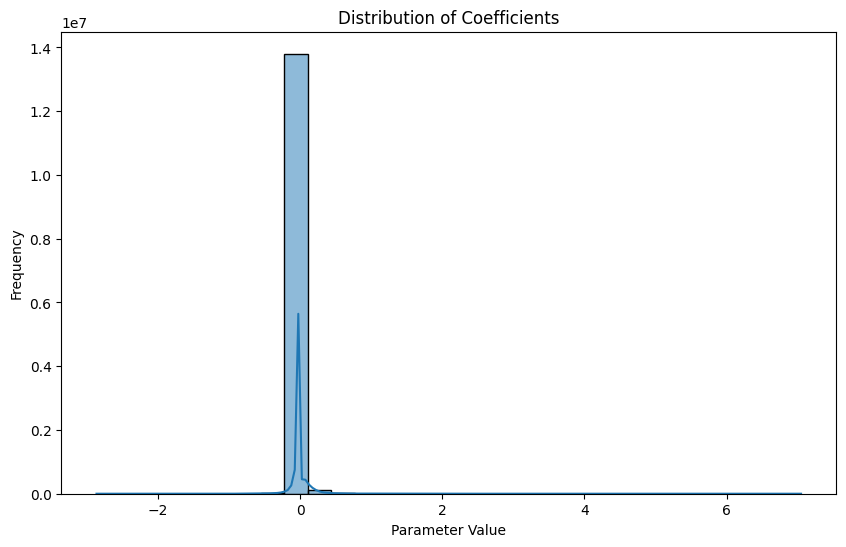

In [45]:
plot_parameter_distribution(estimator, parameter="coefficients")

The model have a very high concentration of coefficients (10,000,000) around zero. This could be and indication that most features have a very small impact on the model's predictions, and only a few features might be driving the model's decisions.

In [46]:
intercept = estimator.intercept_

In [47]:
intercept

array([-0.62448832,  1.29850673, -0.39640402, -3.32927739,  0.35478356,
       -1.29457052, -0.70787602,  0.73328893, -1.86704949,  0.24662413,
       -1.24903296, -0.96001324,  0.78791426, -1.18216649, -0.87924268,
       -0.30190192,  1.21901719,  2.08594901, -0.02355054, -0.7658075 ,
       -0.37627244, -0.76349209,  0.48658446, -0.48159562,  2.2865409 ,
       -0.5424502 ,  0.39047132, -0.23264816,  1.95090987, -0.4136307 ,
       -1.45563007,  2.30903596, -0.24588711, -1.02262435, -1.38153718,
       -0.84017095, -0.67616771, -0.9558044 ,  0.97178628,  0.35144896,
       -0.50524615, -1.71728841, -0.84878844, -3.57661395,  0.37889253,
       -0.24893785, -0.52096418, -1.48256211, -1.24332555, -0.9033324 ,
        0.94957608, -1.66309844, -1.48465416,  0.68335051, -0.17413334,
        0.44123565,  2.4570321 ,  1.31548055, -1.84541845, -1.01506312,
       -2.00194788, -0.7211041 , -1.53503597, -1.93853677, -1.21300802,
       -0.84607456, -1.41228994, -1.59985758, -1.43344927, -1.67

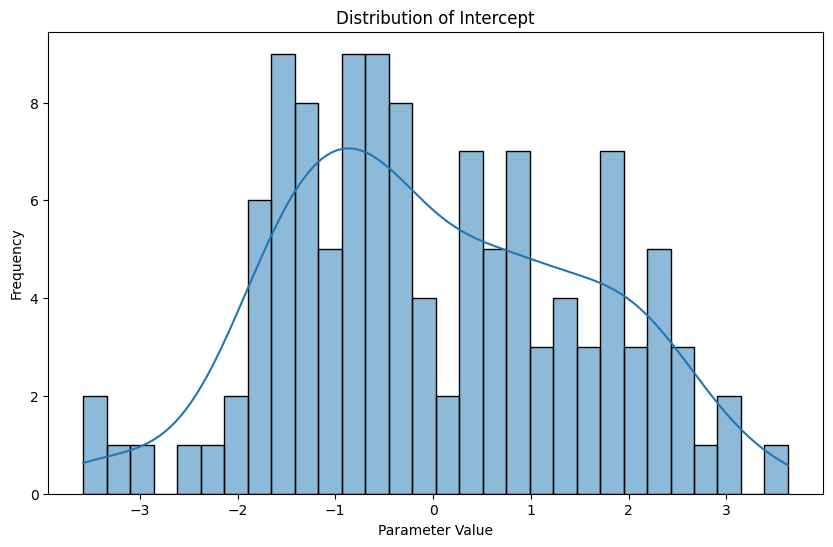

In [48]:
plot_parameter_distribution(estimator, parameter="intercept")

Having most of our coefficents around 0 and most of our intercepts away from zero may be an indication of a high noise in the data. Expected with the textual data.

### **5.4. Model interpretation**

> Let's dig deeper!

Let's make a function to evaluate our model performance.

In [49]:
model_name = joblib.load("saved_models/logistic_best_model_4.joblib")

In [50]:
def evaluate_model(model_name, X_train, y_train, X_test, y_test):
    
    # Make predictions on both train and test sets
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Evaluate performance on both sets
    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)

    # Generating classification reports for more details
    train_report = classification_report(y_train, train_predictions, zero_division=0)
    test_report = classification_report(y_test, test_predictions, zero_division=0)

    return train_accuracy, test_accuracy, train_report, test_report

In [53]:
# Evaluate Logistic Regression model
train_acc, test_acc, train_report, test_report = evaluate_model(model_name, X_train, y_train, X_test, y_test)
print(f"Training Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")
print(f"Training Classification Report:\n{train_report}")
print(f"Test Classification Report:\n{test_report}\n")

Training Accuracy: 0.9997014628321226
Test Accuracy: 0.6935933147632312
Training Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00       104
           3       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00        48
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         7
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00         1
          17       1.00      1.00      1.00         1
          18       1.00      1.

As we can see, every model overfits with the training data. The difference between training and testing accuracy varies between 30% - for the logistic regression model and SVC and more than 60% for the tree. Looking at the testing result we can say that we have a significant imbalance in our classes. But let's dig deeper!

Looking at the test set classification report we can see that the model performs well on some classes but very poorly on others, especially those with fewer instances (low support):

- Some classes like 6, 19, 37, 44, 62, 63, 68, 72, 74, 75, 78, 108, 122, and 129 show high precision, indicating good performance for these specific classes. However, the recall varies significantly, indicating that the model's ability to detect all positive samples of a class is not consistent and gives false positives matches.
- Many classes (e.g., 3, 5, 7, 8, 10, 14, 15, 16, 17, 18, 21, 22, 24, 25, 27, 28, 29, 31, 32, 35, 36, 39, 41, 42, 46, 47, 49, 52, 53, 54, 56, 57, 61, 58, 60, 67, 76, 94, 97, 99, 101, 103, 105, 111, 112,113, 115, 117, 122, 123, 125, 126, 127, 128, 130, 137) have precision, recall, and F1-score of 0.00. This is expected because they have only few samples as support number. However a small number of these classes overfit.
- Macro Average (average of the metric across classes) for precision, recall, and F1-score are all around 0.34, which is low but keeping in mind that we have a lot of minority classes.
- Weighted Average (average of the metric, weighted by support) for precision, recall, and F1-score are better (around 0.68), indicating that the model performs better on more frequent classes.
    
Nice, it looks like we have high variance and high bias too!

We will use dimensionality reduction, to simplify our model. We will use the `parent_id` as target variable instead of `category_id` for the minority classes.


## **6. Model optimization, selection, inspection and interpretation**

### **6.1. Classes transformation**

Before we retrain our model let's make some feature engineering. We will transform the `category_id` of every sample belonging to a minority class to its `parent_id`. 

In [54]:
books_features.groupby("category_id").size()

category_id
1         5
2       130
3         5
5         2
6        60
       ... 
134     786
135    1185
136     198
137       1
138      79
Length: 124, dtype: int64

In [55]:
def update_to_top_level_parent_id(category_id):
    while category_id in specific_ids and category_id in parent_id_mapping:
        category_id = parent_id_mapping[category_id]
    return category_id

In [56]:
specific_ids = [3, 5, 7, 8, 10, 14, 15, 16, 17, 18, 21, 22, 24, 25, 27, 28, 29, 31, 32, 35, 36, 39, 41, 42, 46, 47, 49, 52, 53, 54, 56, 57, 61, 58, 60, 67, 76, 94, 97, 99, 101, 103, 105, 111, 112,113, 115, 117, 122, 123, 125, 126, 127, 128, 130, 137]
parent_id_mapping = books_category.set_index("id")["parent_id"].to_dict()

In [57]:
books_features.category_id = books_features.category_id.apply(update_to_top_level_parent_id)

We still have categories with less than 4 samples.

In [58]:
# Group by category_id and count the number of samples in each category
category_counts = books_features.groupby("category_id").size()

# Filter categories where the count is less than or equal to 2
small_categories = category_counts[category_counts <= 3]

# Display the counts for these categories
small_categories


category_id
13.0    2
40.0    1
43.0    1
48.0    1
62.0    3
81.0    2
dtype: int64

We will impute them with their `parent_id` too.

In [59]:
specific_ids = [13 , 40, 43, 48 , 62, 81]
parent_id_mapping = books_category.set_index("id")["parent_id"].to_dict()
books_features.category_id = books_features.category_id.apply(update_to_top_level_parent_id)

In [60]:
books_features.groupby("category_id").size()

category_id
1.0        104
2.0        130
6.0         60
7.0          2
9.0          6
          ... 
134.0      786
135.0     1185
136.0      198
138.0       79
1067.0     172
Length: 66, dtype: int64

Yes there is imbalance again, but who can blame the people's taste about books. After all we decreased the number of classes from 124 to 66. OK, let's go ahead and simplify the model.

### **6.2. Dimensionality reduction**

We will apply `TruncatedSVD` over all text features and `PCA` over the numerical. To selecct our best solver we included the `solver` hyper parameter in the grid. We will make stratification over the target variable. We will use `L1` regularisation with the `liblinear` kernel to try to make make some sort of feature selection, because this type of regularization can make some of the coefficients = 0.

### **6.3. Training**

Defining feature columns

In [61]:
text_features = ["title", "author", "content_type", "publisher", "translator", "nationality"]
num_features = ['page_count']

Splitting the data. We will stratify the split this time to ensure that we have representation from all classes.

In [76]:
X = books_features.drop(columns="category_id") 
y = books_features["category_id"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [261]:
# preprocessor ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('annotation_svd', make_pipeline(TfidfVectorizer(), TruncatedSVD()), 'annotation'),
    ('text_svd', make_pipeline(OneHotEncoder(handle_unknown='ignore'), TruncatedSVD()), text_features),
    ('num_pca', make_pipeline(StandardScaler(), PCA()), num_features)
])

# pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=10000, random_state=42))
])

# parameter grid
param_grid = [
    {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__class_weight': [None, 'balanced'],
        'classifier__solver': ['liblinear'],
        'classifier__penalty': ['l1'],
        'preprocessor__annotation_svd__truncatedsvd__n_components': [50, 100, 150],
        'preprocessor__text_svd__truncatedsvd__n_components': [50, 100, 150],
        'preprocessor__num_pca__pca__n_components': [0.85, 0.95, 0.99]
    },
    {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__class_weight': [None, 'balanced'],
        'classifier__solver': ['newton-cg', 'lbfgs'],
        'classifier__penalty': ['l2'],
        'preprocessor__annotation_svd__truncatedsvd__n_components': [50, 100, 150],
        'preprocessor__text_svd__truncatedsvd__n_components': [50, 100, 150],
        'preprocessor__num_pca__pca__n_components': [0.85, 0.95, 0.99]
    }
]

# Assuming X_train and y_train are already defined
# Apply GridSearchCV
gs = GridSearchCV(pipeline, param_grid, cv=5)
gs.fit(X_train, y_train)
print(f"Best params: {gs.best_params_}")
print(f"Best score: {gs.best_score_}")

# Save the best model
best_model = gs.best_estimator_
joblib.dump(best_model, "saved_models/logistic_best_model_9.joblib")


C:\Users\Preslav\Documents\Softuni\Machine_Learning\venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best params: {'classifier__C': 100, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'preprocessor__annotation_svd__truncatedsvd__n_components': 150, 'preprocessor__num_pca__pca__n_components': 0.99, 'preprocessor__text_svd__truncatedsvd__n_components': 150}
Best score: 0.6116042980716131


['saved_models/logistic_best_model_9.joblib']

### **6.4. Model selection**

As we can see the difference between Training Accuracy: 0.80 and Test Accuracy: 0.61 decreases from 30% in the initial training to 19% with dimensionality reduction and merging classes. Our model still overfits.

We have our report from the grid search below:

    Best params: {'classifier__C': 100, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'preprocessor__annotation_svd__truncatedsvd__n_components': 150, 'preprocessor__num_pca__pca__n_components': 0.99, 'preprocessor__text_svd__truncatedsvd__n_components': 150}
    Best score: 0.6116042980716131

- Grid search selected C = 100 with L2 combined with 'lbfgs' solver. It may be because the model will overfit more with our data if it penalizes more with smaller C.
- The maximum values of TruncatedSVD and PCA suggest that the model tends to keep the variance in the our data which is expected with unstructured data as long texts.

### **6.5. Model inspection**

In [63]:
model = joblib.load("saved_models/logistic_best_model_9.joblib")

In [64]:
estimator = model.named_steps["classifier"]

In [65]:
coefficients = estimator.coef_

In [66]:
intercept = estimator.intercept_

In [67]:
estimator.coef_.min()

-32.76684354891626

In [68]:
estimator.coef_.max()

27.139424855043394

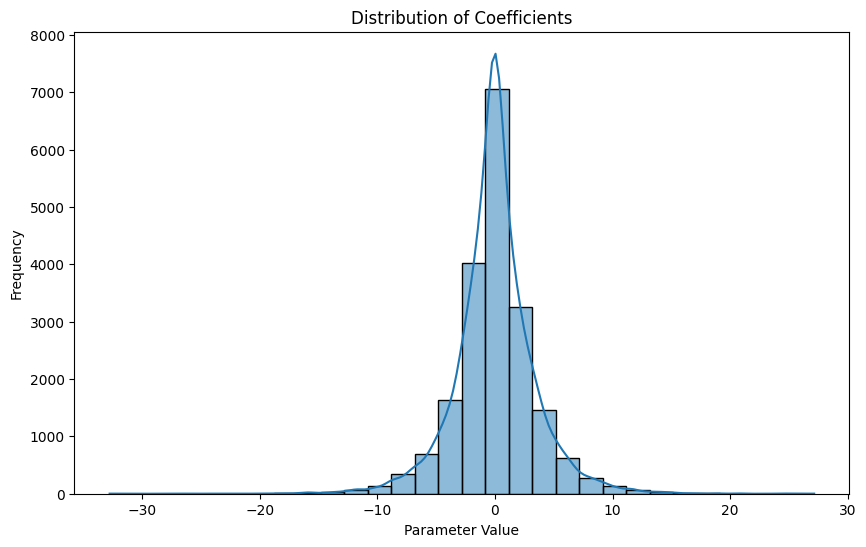

In [69]:
plot_parameter_distribution(estimator, parameter="coefficients")

After the transformations the distribution is wider with a more even spread of coefficients. Again most of the coefficents are close to 0 but other coefficients are spread out over a range of values. This is expected after the Dimensionality reduction and the resampling of classes. 

In [70]:
intercept

array([ 2.55399771,  1.32938991,  1.94684623, -1.85388097, -0.03988484,
       -1.26271663, -1.76327705,  3.412733  ,  1.75076916,  1.68323765,
        3.12734163,  4.02134957,  1.51761683, -2.15565482,  1.5016003 ,
        0.46544858,  1.47987982, -4.35114738,  1.49509767, -1.19800622,
       -1.59005985,  2.8720104 , -1.66784121, -5.49161601, -9.50960191,
       -5.39928124, -3.90511548, -5.79347967, -4.895805  , -2.76869402,
       -1.00531814, -3.93205648, -5.47637797, -7.67046018, -3.17471602,
       -3.0026326 , -4.47544168,  2.33775615, -7.16535015,  1.40222127,
       -4.44113873,  1.98169025,  3.70121016,  3.71342577,  2.69938625,
        2.01209528,  2.19979311,  0.64088027, -1.91136362,  3.84091668,
        4.46170143,  1.35716286,  1.02692879,  1.79539714,  2.22232479,
        3.82504222,  3.81615819, -0.62171137,  4.65165015,  1.86659915,
        1.93358737,  3.44447405,  2.83683936,  1.25222926,  3.17341083,
        5.17243   ])

In [71]:
intercept.min()

-9.509601912269844

In [72]:
intercept.max()

5.17242999563668

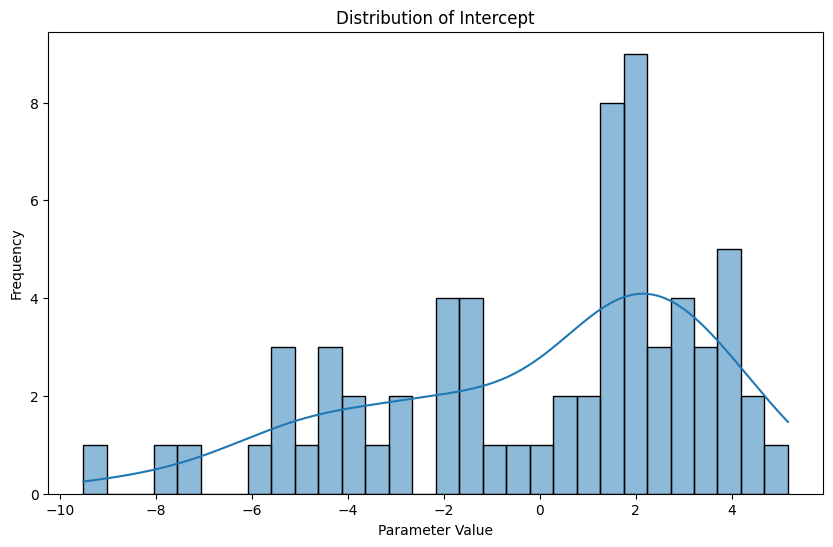

In [73]:
plot_parameter_distribution(estimator, parameter="intercept")

The spread and skewness of intercepts can have implications for the bias of the model.

### **6.6. Model interpretation**

In [77]:
train_acc, test_acc, train_report, test_report = evaluate_model(model, X_train, y_train, X_test, y_test)
print(f"Training Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")
print(f"Training Classification Report:\n{train_report}")
print(f"Test Classification Report:\n{test_report}\n")

Training Accuracy: 0.8079410886655388
Test Accuracy: 0.6032630322323915
Training Classification Report:
              precision    recall  f1-score   support

         1.0       0.88      0.86      0.87        83
         2.0       0.93      0.94      0.94       104
         6.0       0.92      0.96      0.94        48
         7.0       1.00      0.50      0.67         2
         9.0       1.00      0.80      0.89         5
        12.0       1.00      1.00      1.00         6
        19.0       1.00      1.00      1.00        25
        20.0       1.00      0.96      0.98        28
        30.0       0.96      0.94      0.95        52
        33.0       1.00      1.00      1.00         3
        34.0       1.00      0.92      0.96        25
        37.0       0.96      0.92      0.94        50
        38.0       0.98      0.89      0.93        53
        39.0       1.00      1.00      1.00         2
        44.0       1.00      1.00      1.00        18
        45.0       0.97      1.

**Training Performance:**
- The model achieves an accuracy of approximately 80.5% on the training set. This indicates that it is able to correctly predict the outcome for a significant majority of the training data.
- The classification report shows high precision and recall for several classes, which means the model is correctly identifying a high number of true positives and not misclassifying many negatives as positives for those classes.
- However, some classes (class 7.0 and 39.0) have no instances, indicated by precision, recall, and f1-score all being 0. This could be due to a lack of representation of these classes in the training data.
- The model performs exceptionally well for certain classes (class 19.0, 33.0, and 88.0) with perfect precision, recall, and f1-scores of 1.0, suggesting these classes have distinctive features that are easily recognized by the model.
- The weighted average f1-score is consistent with the overall accuracy, which indicates a good balance between precision and recall across all classes, weighted by the number of true instances for each class.

**Test Performance:**
- There is a significant drop in accuracy when the model is applied to the test set, with an accuracy of approximately 61.3% but better when comparing with the previous training. The model may not generalize well to unseen data, a sign of potential overfitting to the training data.
- The precision and recall values are lower on the test set across most classes, and the f1-scores follow, which is typical as the model is now being evaluated on data it hasn't seen before.
- For several classes, precision and recall are significantly lower on the test set compared to the training set (class 1.0, class 2.0), indicating a loss of predictive power.
- Some classes show particularly low recall (class 79.0, class 118.0) on the test set, meaning the model misses a high number of actual positives for these classes when making predictions.
- The weighted average f1-score on the test data is lower than the training data, as expected from the overall reduced performance.


The discrepancy between training and test performance suggests that the model may be overfitting to the training data. The model's high bias towards certain classes could be due to class imbalance in the training data, where some classes have many more samples than others, leading the model to predict more frequently occurring classes better. Model complexity, feature selection, and the regularization applied might need to be adjusted to improve the model's generalization capabilities. It might be good to look into other resampling techniques, gathering more data, or feature engineering to improve the model's ability to generalize. 

In [ ]:
books_category

### **6.7. Inference with never seen and fictional data**

In [4]:
import joblib
import pandas as pd
model = joblib.load('saved_models/logistic_best_model_9.joblib')

In [5]:
never_seen = pd.read_csv("never_seen_data.csv")

In [6]:
predictions = model.predict(never_seen)

In [10]:
id_to_name = dict(zip(books_category.id, books_category.name))
never_seen["predictions"] = [id_to_name[pred] for pred in predictions]

In [11]:
never_seen

,Unnamed: 0,title,author,annotation,content_type,publisher,nationality,translator,page_count,predictions
0,0,Избрани творби,Христо Ботев,Вярвам е единната обща сила на человеческий ро...,стихосбирка; разкази,Издателство Български писател,българска,Missing,208.0,"Наука, технологии, образование"
1,1,Смъртта е занимание самотно,Рей Бредбъри,"Мъгливо градче в щата Калифорния, където време...",роман,Сиела Норма АД,американска,Жени Божилова,271.0,Научна фантастика
2,2,Залезът на боговете,Фридрих Ницше,В книгата Ницще обръща внимание на настъпилото...,Философски сборник,NaN,немска,Георги Кайтазов,100.0,История
3,3,Истории от гетото,Мишо Шамара,Книгата е своеобразна изповед на един рапър из...,Разказ,Георги Кирков,българска,Missing,250.0,Българска документална проза
4,4,Как НАСА създава екипи,Чарлс Дж. Пелерин,"Мислите, че традиционните семинари за изгражда...",Изследвания,Инфодар,американска,Александра Павлова,348.0,Биографии и автобиографии
5,5,Боксьорът. Истинската история на Херцко Хафт,Райнхард Клайст,Преди да навърши 16 години Херцко Хафт попада ...,Графичен роман,Еастра,немска,Добринка Лазарова,200.0,Документална проза
6,6,Хаджи Димитър,Христо Ботев,Книжката включва стихотворението Хаджи Димитър...,стихосбирка; разкази,Издателство Български писател,българска,Missing,16.0,Съвременна българска поезия
7,7,Под Игото,ИВан Вазов,Романът пресъздава живота на един поробен наро...,роман,Български писател,българска,Missing,436.0,Съвременни български романи и повести


As we can see the model can generalize in column predictions over unknown data. It gives plausible results over non existing books too (Истории от гетото, Мишо Шамара). We can predict the category of books from the new dataset with relative success. Actualy the model doesn't have information about which Bulgarian writer is from the times of the Bulgarian Renaissance but as a whole predict surelly whether it is not foreign author.

## **7. Conclusions**

#### Overfitting Issue:
   - Even though we decreased the overfitting of the model, some minority classes still overfit. However the gap between tarining and testing results decreased.

#### Handling of Minority Classes:
   - While it also faces challenges with classes having no instances the overall performance of classes appears more balanced when we simplified the model/data .

#### Class Imbalance:
   - The data has significant class imbalance, but can be handled with undersampling of the majority class or oversampling the minority.

#### Model complexity:
   - Logistic regression as a not very complex model performs relatively well, but the use of ensemble models should be considered. With unstructured data, the best results would be the use of neural network.


Let's try to "Judge the book by its cover"!

## **8. Inference from a book cover with GPT 4**

We use the GPT 4 API to search information about a book by its cover image. 

In [79]:
def analyze_image_with_openai(image_path, api_key):
    """
    Analyze an image using OpenAI's API.

    :param image_path: Path to the image file.
    :param api_key: OpenAI API Key.
    :return: The API's response as a JSON object.
    """
    def encode_image(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')

    # Getting the base64 string
    base64_image = encode_image(image_path)

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    payload = {
        "model": "gpt-4-vision-preview",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "What’s in this image?"
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
        "max_tokens": 300
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()

We use the cover of the book "House of cards"

In [80]:
# Example Usage
api_key = "YOUR-API-KEY"
image_path = "covers/4_cover.jpg"
result = analyze_image_with_openai(image_path, api_key)
print(result)

{'id': 'chatcmpl-8QZNMwPmTQeCe3GdbtSCuBOqAk11Q', 'object': 'chat.completion', 'created': 1701343204, 'model': 'gpt-4-1106-vision-preview', 'usage': {'prompt_tokens': 778, 'completion_tokens': 249, 'total_tokens': 1027}, 'choices': [{'message': {'role': 'assistant', 'content': 'This image is of a book cover. The title of the book is "Къща от карти" which translates to "House of Cards" from Bulgarian. The author\'s name is "Майкъл Добс" or Michael Dobbs in English. Below the title, there\'s a tagline in Bulgarian that reads: "Бестселърът, който вдъхнови хитовата серия на Netflix КЪЩА ОТ КАРТИ" which translates to "The bestseller that inspired the hit Netflix series HOUSE OF CARDS."\n\nThe cover features an image of a leather armchair with visible signs of wear and tear, including what appears to be slashes on the backrest, suggesting damage or violence. The background is dark, with silhouettes of what seems to be a cityscape or possibly iconic buildings that may be related to the politic

As we can see the cover of the Bulgarian edition of "House of cards" gives us the whole information to classify the book. 
- Title: "Къща от карти"
- Author: "Майкъл Добс"
- Publisher: "CIELA"
- nationality: "Bulgarian"
- Annotation: "A translation of Michael Dobbs's novel "House of Cards", which inspired the popular television series of the same name.  "
- Category: political drama

We use the cover of the book "The Shining"

In [81]:
api_key = "YOUR-API-KEY"
image_path = "covers/177_cover.jpg"
result = analyze_image_with_openai(image_path, api_key)
print(result)

{'id': 'chatcmpl-8QZO4jh8gmEYLPblGFGf7skin8zAd', 'object': 'chat.completion', 'created': 1701343248, 'model': 'gpt-4-1106-vision-preview', 'usage': {'prompt_tokens': 1118, 'completion_tokens': 179, 'total_tokens': 1297}, 'choices': [{'message': {'role': 'assistant', 'content': 'This is an image of a book cover that appears to be in Cyrillic script. The Cyrillic text at the top is likely the author\'s name, which reads something similar to "СТИВЬН КИНГ", a transliteration of "Stephen King" in English. Below it, there\'s a larger title that reads "СИЯНИЕ", which translates to "The Shining", a well-known novel by Stephen King.\n\nOn the cover art, there\'s an illustration of a young boy who appears to be frightened or concerned. He is wearing a sweater and is hugging his knees. The style of the artwork suggests it\'s an older edition or a version published for a non-English market. The book "The Shining" is a horror novel, and the portrayal of the boy on the cover captures the unsettling 

Again we have full information about the book, from its cover!

## **9. References**

- [Softuni Machine Learning - септември 2023](https://softuni.bg/trainings/4060/machine-learning-september-2023)
- ["Book Genre Categorization Using Machine Learning Algorithms (K-Nearest
Neighbor, Support Vector Machine and Logistic Regression) using Customized
Dataset"](https://www.researchgate.net/publication/350102357_Book_Genre_Categorization_Using_Machine_Learning_Algorithms_K-Nearest_Neighbor_Support_Vector_Machine_and_Logistic_Regression_using_Customized_Dataset)
- ["Judging a Book By its Cover"](https://arxiv.org/pdf/1610.09204v3.pdf)
- [GPT 4 API](https://platform.openai.com/docs/guides/vision)